In [1]:
import torch
from agents.debn_ps import *
from environments.env_gridworld import *
from tqdm import tqdm 
from torchsummary import summary
from torch import tensor

import seaborn as sns
import matplotlib
%matplotlib inline 
import  matplotlib.pyplot as plt
from IPython.display import display, clear_output
sns.set()

from qumcmc.classical_mcmc_routines import * 
from qumcmc.quantum_mcmc_routines_qulacs import *
from qumcmc.energy_models import IsingEnergyFunction, Exact_Sampling
from qumcmc.basic_utils import plot_multiple_bargraphs
from agents.enhanced_samplng import *

#### **PREPARE AGENT AND ENVIRONMENT**

In [2]:
# INTERACTION PARAMETERS #
#------------------------#
EPISODES = 100  # number of episodes for each agent 2000
MAX_STEPS_PER_TRIAL = 50  # number of allowed timesteps before reset 20000

#agent parameters
AGENT_NUMBER = 1
DEVICE = 'cpu'
AGENT_NAME = 'ebm'

GAMMA = 0.99 # discount factor
hidden_layers = 1 # number of hidden layers
hidden_units_layer = 5 # number of hidden units
NUM_HIDDEN = [int(round(hidden_units_layer))]*hidden_layers # list of hidden unit numbers list
DROPOUT = [0.]*hidden_layers # dropout rate list
LEARNING_RATE = 0.001 # learning rate
CAPACITY = 500 # size of the memory
BATCH_SIZE = 100 # size of the training batch for experience replay
REPLAY_TIME = 50 # the time interval between each experience replay
TARGET_UPDATE = 100 # update interval for the target network
SAVE_MODEL = False #set to true to save state dict

BETA_i = 0.001 # initial beta parameter for schedule
BETA_f = 0.08 # final beta parameter for schedule
SCHEDULE = 'htan' # name of the schedule
if SCHEDULE == 'htan':
    beta = np.tanh(np.linspace(BETA_i, BETA_f, EPISODES)) # tanh schedule
elif SCHEDULE =='lin':
    beta = np.linspace(BETA_i, BETA_f, EPISODES) # linear scchedule

# ENVIRONMENT PARAMETERS
ENV_NAME = 'gridworld' # environment name
DIMENSIONS = [4,4] # 2D grid of size [10,10]
env = TaskEnvironment(DIMENSIONS) #generate environment

## 'percept_size' depends on the encdoing 
percept_size_oneh = DIMENSIONS[0]*DIMENSIONS[1] #size of the percept space 
percept_size_twoh = DIMENSIONS[0]+DIMENSIONS[1] #size of the percept space

action_size = 4 # size of the action space

#action encoding
all_actions = torch.empty(0)
for i in range(action_size):
    a = torch.zeros((1, 1, action_size))
    a = a.new_full((1, 1, action_size), 0.)
    a[0, 0, i] = 1.
    all_actions = torch.cat((all_actions, a))

#percept encoding
def to_two_hot(percept, dim):
    """
    Two-hot encodes the 2D percept of positions.
    """
    two_hot = np.zeros(dim[0]+dim[1]) ##added
    two_hot[percept[0]] = 1
    two_hot[dim[0]+percept[1]] = 1
    return two_hot


#percept encoding
def to_one_hot(percept, dim):
    """
    One-hot encodes the 2D percept of positions.
    """
    one_hot = np.zeros(dim[0]*dim[1]) ## multiplied
    
    one_hot[dim[0]*percept[0] + percept[1]] = 1
    
    return one_hot    

# DEFINE AGENT           #
#------------------------#
agent = DEBNAgent(percept_size_twoh, action_size, all_actions, dim_hidden=NUM_HIDDEN, dropout_rate=DROPOUT,
                    device = DEVICE, learning_rate=LEARNING_RATE, capacity=CAPACITY, batch_size=BATCH_SIZE, replay_time=REPLAY_TIME,
                    target_update = TARGET_UPDATE, gamma = GAMMA, train_output_weights = False)

# EPISODES = 100
# MAX_STEPS_PER_TRIAL = 100
verbose = False
coords = []
# RUN TRAINING STEPS     #
#------------------------#
timesteps = []
for e in tqdm(range(EPISODES), desc= 'running episodes'):
    counter = 0
    #reset the environment
    percept = env.reset()
    coords.append(percept) ## coords stroing 
    # percept = to_one_hot(percept,DIMENSIONS)
    # percept = np.reshape(percept, [1, percept_size_oneh])
    percept = to_two_hot(percept,DIMENSIONS)
    percept = np.reshape(percept, [1, percept_size_twoh])
    percept = torch.Tensor(percept)
    reward = 0.
    done = False
    # for t in tqdm(range(1, MAX_STEPS_PER_TRIAL + 1), desc= 'runnnig episode . .. '+str(e) ):
    for t in range(1, MAX_STEPS_PER_TRIAL + 1):
        
        action = agent.deliberate_and_learn(percept, None, reward, GAMMA, done, beta[e])
        action = (action[0] == 1).nonzero().item()
        percept, reward, done, _ = env.step(action)
        coords.append(percept) ## coords storing 

        if verbose :  print('action : '+str( action) + ' percept : ' + str(percept) + ' reward : '+ str( reward))
        # percept = to_one_hot(percept, DIMENSIONS)
        # percept = np.reshape(percept, [1, percept_size_oneh])
        percept = to_two_hot(percept,DIMENSIONS)
        percept = np.reshape(percept, [1, percept_size_twoh])
        percept = torch.Tensor(percept)
        
        if t==MAX_STEPS_PER_TRIAL:
            reward = -1
            done = True
        if done:
            agent.deliberate_and_learn(percept, None, reward, GAMMA, done, beta[e])
            timesteps.append(t)
            break

    if e%100 == 0:
        if verbose : print("Average last 100 scores (timesteps per episode) the agent achieved at " + str(e) + ": ", np.mean(timesteps[-100:]))
        # save data to file

## get trajectory plotting data ##
xs = []; ys = []
for coord in coords: 
    xs.append(coord[0])
    ys.append(coord[1])

running episodes: 100%|██████████| 100/100 [00:05<00:00, 19.75it/s]


##### Visualise trajectory

In [3]:
# ## visualise trajectory dynamically ## not very efficeint
# plt.figure(figsize=(12,12))
# for coord in tqdm(coords) :
#     plt.plot(coord[0], coord[1], 'o', 'r')
#     clear_output(wait= True)
#     plt.show()

In [4]:
# ## visualise spots visited  ##
# plt.figure(figsize=(12,12))
# # for coord in tqdm(coords) :
# #     plt.plot(xs, ys, '-o', 'r')
# plt.scatter(xs, ys )
# plt.show()

#### **TEST SAMPLING**

            MODEL : DEBN
Non-zero Interactions (J) : 60 / 136
Non-zero Bias (h) : 17 / 17
---------------------------------------------
Average Interaction Strength <|J|> :  0.15221341924941664
Average Bias Strength <|h|>:  0.13867557
alpha :  1.226453396223818
---------------------------------------------


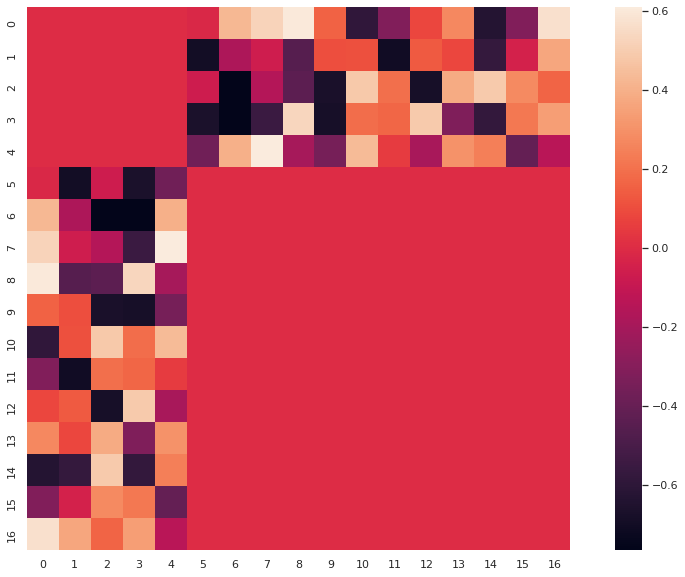

In [5]:
net_model = build_energy_model(agent.policy_net)
net_model.model_summary()

##### Classical Sampling

In [6]:
rsmpc = RestrictedSampling(net_model, hidden_units_layer, action_size, percept_size_twoh, percept_to_str(percept))
clchn = rsmpc.run_classical_mcmc(100, verbose= False);
cdct = clchn.get_accepted_dict(normalize= True)

##### Quantum Sampling

In [7]:
rsmpq = RestrictedSampling(net_model, hidden_units_layer, action_size, percept_size_twoh, percept_to_str(percept))
qchn = rsmpq.run_quantum_enhanced_mcmc(100, verbose=True)
qdct = qchn.get_accepted_dict(normalize=True)

current state:  MCMCState(hidden='10111', action='1101', state='01000010', accepted=True)


runnning quantum MCMC steps . ..: 100%|██████████| 100/100 [03:31<00:00,  2.11s/it]


In [12]:
percept, percept_to_str(percept)

(tensor([[0., 1., 0., 0., 0., 0., 1., 0.]]), '01000010')

In [13]:
dict(zip(agent.all_actions, agent._choose_action(percept, return_prob_vals= True)))

{tensor([[1., 0., 0., 0.]]): 0.28334098495233245,
 tensor([[0., 1., 0., 0.]]): 0.2610121782132641,
 tensor([[0., 0., 1., 0.]]): 0.19028911634221038,
 tensor([[0., 0., 0., 1.]]): 0.26535772049219297}

In [14]:
qdct

Counter({'110101000010': 0.08333333333333333,
         '011101000010': 0.08333333333333333,
         '001101000010': 0.08333333333333333,
         '100001000010': 0.25,
         '100101000010': 0.16666666666666666,
         '011001000010': 0.08333333333333333,
         '111001000010': 0.08333333333333333,
         '000101000010': 0.16666666666666666})

In [15]:
cdct

Counter({'000001000010': 0.75, '011001000010': 0.25})